<a href="https://colab.research.google.com/github/giovannasantoloni/Projetos-de-Sistemas-Inteligentes-de-Apoio-Decis-o/blob/main/Projeto_Final_Curso_BI_Master_2021_1_Giovanna_Dohnert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Final Curso BI Master 2021-1
> Por Giovanna Santoloni Dohnert

In [1]:
#Montagem do Drive 
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
#Importar Bibliotecas
import numpy as np
import pandas as pd
import os
import shutil
import cv2
from glob import glob
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
import random
import shutil


In [3]:
#Importar Aplicações
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from scipy import ndimage, misc
import skimage
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Sequential
from keras.layers.pooling import GlobalAveragePooling2D
from keras.models.cloning import training
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import LearningRateScheduler


In [4]:
# Caminho da Base de Dados
import os
workdir_path = '/content/drive/My Drive/Projeto Final BI/images' 
os.chdir(workdir_path)


In [5]:
# Caminho do dataset
full_dataset = r'/content/drive/My Drive/Projeto Final BI/images'

# Definição de Parâmetros:
A definição de parâmetros em um modelo de classificação de imagens é essencial para que o modelo possa aprender a partir dos dados de treinamento e, posteriormente, ser capaz de classificar novas imagens de forma precisa. A escolha adequada dos parâmetros pode melhorar significativamente a precisão do modelo e sua capacidade de generalização para novos dados. 


In [6]:
#Definição de Parâmetros

#Número de Classes 
n_classes = 10

#Tamanho das Imagens
target_size = (512, 512)

#Tamanho do Lote para Treinamento
batch_size = 32


In [7]:
# Olhando o número de arquivos por classe
for nome_pasta in os.listdir(full_dataset):
    caminho_pasta = os.path.join(full_dataset, nome_pasta)
  
    if os.path.isdir(caminho_pasta):
        
        lista_arquivos = os.listdir(caminho_pasta)  

        num_arquivos = len(lista_arquivos)     

        print("Pasta:", nome_pasta, " - Número de arquivos:", num_arquivos)

Pasta: Havana  - Número de arquivos: 184
Pasta: Munchkin  - Número de arquivos: 181
Pasta: Pixiebob  - Número de arquivos: 111
Pasta: Sphynx  - Número de arquivos: 209
Pasta: Exotic Shorthair  - Número de arquivos: 232
Pasta: Cornish Rex  - Número de arquivos: 171
Pasta: American Bobtail  - Número de arquivos: 210
Pasta: Maine Coon  - Número de arquivos: 267
Pasta: British Shorthair  - Número de arquivos: 213
Pasta: Siamese  - Número de arquivos: 210


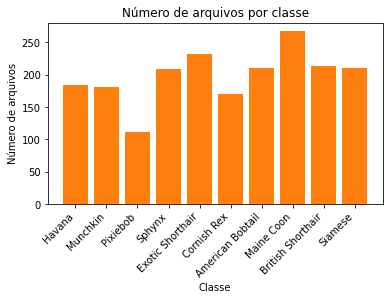

In [8]:
# Criando as listas para armazenar os dados
classes = []
num_arquivos = []

# Olhando o número de arquivos por classe
for nome_pasta in os.listdir(full_dataset):
    caminho_pasta = os.path.join(full_dataset, nome_pasta)
  
    if os.path.isdir(caminho_pasta):
        
        lista_arquivos = os.listdir(caminho_pasta)  

        num_arq = len(lista_arquivos)
        
        classes.append(nome_pasta)
        num_arquivos.append(num_arq)

# Gerando o gráfico de barras
plt.bar(classes, num_arquivos)
plt.title("Número de arquivos por classe")
plt.xlabel("Classe")
plt.ylabel("Número de arquivos")
plt.subplots_adjust(bottom=0.25)
plt.bar(classes, num_arquivos, width=0.8)
plt.xticks(rotation=45, ha="right")
plt.show()

# Data Augmentation

O data augmentation foi utilizada para aumentar a quantidade de dados de treinamento do modelo, através da geração de novas amostras a partir das amostras existentes, aplicando transformações como rotação, espelhamento (...) entre outros.

# Separando o Conjunto de Dados em Treino, Validação e Teste

Separamos o conjunto de dados em treino, validação e teste a fim de avaliar o desempenho do modelo frente a diferentes dados e garantir que ele seja capaz de generalizar de maneira adequada. 

•	Conjunto de Treino: usado para treinar o modelo, ajustar os pesos e os parâmetros do modelo com base nos dados de treinamento.

•	Conjunto de Validação: usado para avaliar o desempenho do modelo em dados que ele não viu durante o treinamento e otimizar os parâmetros do modelo para obter um melhor desempenho.

•	Conjunto de Teste: usado para avaliar o desempenho final do modelo em dados completamente novos que não foram usados para treinamento ou validação.

In [ ]:
# Data Augmentation
image_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, 
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],  # variação no brilho 
    shear_range=0.2,  # corte de perspectiva na imagem
    fill_mode='reflect',  # preenche pixels faltantes 
    channel_shift_range=50.0,  # mudança aleatória nos canais R, G, B
    vertical_flip=True,  # gira a imagem de cabeça para baixo
    featurewise_center=True,  # centralização da imagem com base na média dos pixels
)

# Separando o Conjunto de Dados em Treino e Validação
train_dataset = image_generator.flow_from_directory(batch_size=batch_size, 
                                                    directory=full_dataset ,
                                                    shuffle = True,
                                                    target_size =target_size,
                                                    subset ="training",
                                                    class_mode = 'categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=batch_size, 
                                                    directory=full_dataset,
                                                    shuffle = True,
                                                    target_size =target_size,
                                                    subset ="validation",
                                                    class_mode = 'categorical')

# Fit do gerador de imagens
image_generator.fit(train_dataset)

Found 1594 images belonging to 10 classes.
Found 394 images belonging to 10 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


In [ ]:
# Separando o conjunto de Teste
image_generator = ImageDataGenerator(rescale=1./255)

test_dataset = image_generator.flow_from_directory(batch_size=batch_size, 
                                                    directory=full_dataset,
                                                    shuffle = True,
                                                    target_size =target_size,
                                                    class_mode = 'categorical')

# Utilização do Transfer Learning
O uso de Transfer Learning e pesos pré-treinados do modelo VGG16 ajuda a melhorar a precisão do modelo de classificação de imagens, a reduzir o tempo e o custo de treinamento e a lidar com conjuntos de dados pequenos.


In [ ]:
# carregar a arquitetura VGG16 pré-treinada
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*target_size, 3))

In [ ]:
# adicionar camadas adicionais ao modelo
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x) 

# Adicionamos uma camada de dropout de 0,5, o que significa que metade dos neurônios da camada anterior serão aleatoriamente desativados
# durante o treinamento, para evitar overfitting.

x = Dropout(0.5)(x)  

predictions = Dense(n_classes, activation='softmax')(x)

In [ ]:
# criar modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# congelar as camadas da base
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Learning Rate Adaptativa
def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        lr = lr / 2
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

# compilar o modelo
model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
# Treinar o Modelo
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    epochs=30,
    validation_data=validation_dataset,
    validation_steps=len(validation_dataset),
    callbacks=[lr_scheduler])

In [ ]:
# Avaliando o modelo com conjunto de teste
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_dataset.classes

In [ ]:
# Gerando a Matriz de Confusão
conf_matrix = confusion_matrix(y_true, y_pred)
print("Matriz de Confusão:\n", conf_matrix)

# Conclusões 

O modelo apresentou um desempenho razoável, contudo ainda parece sofrer com overfitting, já que a acurácia no conjunto de validação apresenta-se consideravelmente menor do que a acurácia no conjunto de treinamento. Isso pode ser observado nas diferenças entre as acurácias do conjunto de treinamento e validação nas epochs 1, 2, 3 e 5.

O valor da função de perda (loss) no conjunto de validação também não reduz consistentemente com as epochs, o que sugere que o modelo pode estar estagnado do ponto de vista de aprendizado. Em resumo,  o modelo possa se beneficiará de ajustes nos hiperparâmetros para otimizar seu desempenho.                                                                

A partir da matriz de confusão, podemos observar que o modelo não está performando bem para algumas classes específicas. Por exemplo, para a classe 2, não foi possível prever nenhuma raça corretamente, o que indica que o modelo precisa ser melhorado para esta classe. O modelo também apresentou baixo desempenho para as classes 1, 4 e 7.

Podemos calcular a acurácia do modelo a partir da matriz de confusão, o que aponta para o percentual de corretas em relação ao total de predições: A acurácia é de aproximadamente 53,8%.